In [ ]:
# Code that plots a line graph of m6A/A from a dimelo.db

### PREREQS:
# 1. Make sure you have megalodon output: per_read_modified_base_calls.txt
# megalodon must be run to with the following option: --write-mods-text
# Otherwise you must run the following command to generate the "per_read_modified_base_calls.txt" file that is required
# cd to directory where basecalling was outputted and run: "megalodon_extras per_read_text modified_bases ."

#2. Output methylartist segmeth file:
# cd into basecall folder where per_read_modified_base_calls.txt was outputted:
# methylartist db-megalodon -m per_read_modified_base_calls.txt --db TubeH.megalodon.db

#3. Run methylartist segmeth to gernerate aggregate meth frac by chr bin:
# methylartist segmeth -d megalodon.txt -i /Data1/reference/ce11_200kb_windows_c_noM.bed -p 32
# where megalodon.txt is a tsv with the following format:
# Output_from_previous_command \t original_bam_file.bam
# Otherwise you can skip 2 and just run:
# methylartist segmeth --bam original_bam_file.bam -i /Data1/reference/ce11_200kb_windows_c_noM.bed -p 32

# 4. Make sure you have demelo.db file by using this dimelo script:
# /Data1/git/meyer-nanopore/scripts/Analysis/dimelo-script-enrchment-profile.py
# dm.parse_bam(bam1,"N2_120min",each_out,each_bed,mods,center=True,windowSize=window,threshA=m6A_thresh,cores=coreNum)
# or dm.plot_enrichment_profile will also generate the db tables.


In [2]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import plotly.express as px
from scipy.ndimage.filters import gaussian_filter1d
smooth = 50
min_periods = 10

def prep_segmeth(df):
    df.columns = df.columns.str.replace("mod_mappings.sorted.m6Aonly_", "")
    df.columns = df.columns.str.replace("Y", "m6A")
    df["total_A_calls"]=df["m6A_meth_calls"]+df["m6A_unmeth_calls"]
    df["chr_type"]= ['X' if x == 'CHROMOSOME_X' else 'Autosome' for x in df['seg_chrom']]
    display(df.head(1))
    # Drop end of chromsomes
    df=df.loc[df["seg_start"]>1000000]
    for each in df["seg_chrom"].unique():
        chr_max = float(df.loc[df["seg_chrom"]==each]["seg_start"].max()) - 1000000
        #print(chr_max)
        df=df.drop(df[(df["seg_chrom"] == each) & 
                   (df["seg_start"] < chr_max)].index)
    return df

def weighted_average_A(df):
    weighted_avg = numpy.average(df.loc[df["seg_chrom"] != "CHROMOSOME_X","m6A_methfrac"], 
                              weights=df.loc[df["seg_chrom"] != "CHROMOSOME_X","total_A_calls"])
    return weighted_avg

def prep_region_table(db_filename):
    conn = sqlite3.connect(db_filename)
    dfX = pd.read_sql_query("SELECT * from methylationAggregate_X", conn)
    dfX["m6A_frac"] = dfX["methylated_bases"]/dfX["total_bases"]
    dfX["chr_type"] = "X"
    dfX = dfX.sort_values(by=['pos'],ascending=True)
    dfX = dfX.reset_index(drop=True)
    dfX["m6A_frac_smooth"] = dfX["m6A_frac"].rolling(
        window=smooth, min_periods=min_periods, center=True).mean()
    
    dfA = pd.read_sql_query("SELECT * from methylationAggregate_Autosome", conn)
    dfA["m6A_frac"] = dfA["methylated_bases"]/dfA["total_bases"]
    dfA["chr_type"] = "Autosome"
    dfA = dfA.sort_values(by=['pos'],ascending=True)
    dfA = dfA.reset_index(drop=True)

    dfA["m6A_frac_smooth"] = dfA["m6A_frac"].rolling(
        window=smooth, min_periods=min_periods, center=True).mean()
    
    df = pd.concat([dfX, dfA], axis=0)
    df = df.sort_values(by=['pos'],ascending=True)
    df = df.reset_index(drop=True)
    conn.close()
    return df

def prep_whole_chr_table(db_filename):
    conn = sqlite3.connect(db_filename)
    
    # Get a list of all table names that start with "methylationAggregate_"
    query = "SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'methylationAggregate_%'"
    table_names = pd.read_sql_query(query, conn)
    table_names = table_names['name'].tolist()
    
    # Initialize an empty DataFrame to store the concatenated data
    df = pd.DataFrame()

    # Concatenate all the tables into the DataFrame
    for table_name in table_names:
        query = f"SELECT * FROM {table_name}"
        data = pd.read_sql_query(query, conn)

        # Add a new column named "chromosome" to the DataFrame, remove "methylationAggregate_" from the table name and fill it 
        data['chromosome'] = table_name.replace("methylationAggregate_","")
        df = pd.concat([df, data], ignore_index=True)
    
    df['chr_type'] = 'Autosome'
    df.loc[df['chromosome'] == 'CHROMOSOME_X', 'chr_type'] = 'X'
    df["m6A_frac"] = df["methylated_bases"]/df["total_bases"]
    
    df = df.sort_values(by=['chromosome','m6A_frac'])
    df = df.reset_index(drop=True)
    moving_average_col = df.groupby('chromosome')['m6A_frac'].rolling(
        window=smooth+40, min_periods=min_periods+40, center=True).mean()
    moving_average_col = moving_average_col.reset_index(level=0, drop=True)
    df['m6A_frac_smooth'] = moving_average_col
    conn.close()
    return df

/tmp/ipykernel_2924/928120060.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [3]:
### INGEST SQLite DATA
# SQLite tables to pandas df for TSS
sqlite_filename_4 = "/Data1/seq_data/Tube4_b2_2uM-Hia5_fiber-seq_11_21_22/viz/mod_mappings.sorted.m6Aonly_1_9_22.db"
sqlite_filename_D = "/Data1/seq_data/TubeD1a_N2_Fiberseq_Hia5_MSssI_12_22_22/viz/mod_mappings.commonsorted_1_9_22.db"
sqlite_filename_H = "/Data1/seq_data/TubeH1_021_SDC2-AIDpAux_Hia5_MSssI_12_19/viz/mod_mappings.sorted_1_9_22.db"
TSS_4 = prep_region_table(sqlite_filename_4)
TSS_D = prep_region_table(sqlite_filename_D)
TSS_H = prep_region_table(sqlite_filename_H)

# SQLite tables to pandas df for TSS
wholechr_filename_4 = "/Data1/seq_data/Tube4_b2_2uM-Hia5_fiber-seq_11_21_22/viz/whole_chr/mod_mappings.sorted.m6Aonly.db"
wholechr_filename_D = "/Data1/seq_data/TubeD1a_N2_Fiberseq_Hia5_MSssI_12_22_22/viz/whole_chr/mod_mappings.sorted.db"
wholechr_filename_H = "/Data1/seq_data/TubeH1_021_SDC2-AIDpAux_Hia5_MSssI_12_19/viz/whole_chr/mod_mappings.sorted.db"
whole_chr_4 = prep_whole_chr_table(wholechr_filename_4)
whole_chr_D = prep_whole_chr_table(wholechr_filename_D)
whole_chr_H = prep_whole_chr_table(wholechr_filename_H)
#display(whole_chr_4)
#display(whole_chr_D)
#display(whole_chr_H)

#Available tables
#tables_4 = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",connection_4_wholechr)
#tables_D = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",connection_D)
#tables_H = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",connection_H)
#print(tables_4)



# Import bed file
bed_raw = pd.read_csv("/Data1/reference/tss_tes_rex_combined.bed", delimiter="\t")
#bed_raw = bed_raw.drop(columns=["chr-type"])
#display('bed_raw:',bed_raw.head(1))
#display(bed_raw.type.unique())
#bed_tss = bed_raw[bed_raw['type'].str.startswith('TSS')]
#display('bed_tss:',bed_tss.head(1))
#bed_rex = bed_raw[bed_raw['type'].str.endswith('rex')]
#display('bed_rex:',bed_rex.head(1))

In [4]:
### CALC NORM FACTORS WITH SEGMETH FILE
# Import segmeth.tsv files
#segmeth_tsv_4 = pd.read_csv("/Data1/seq_data/Tube4_b2_2uM-Hia5_fiber-seq_11_21_22/basecalls/ce11_200kb_windows_c_noM.megalodondb.segmeth.tsv", delimiter="\t")
#segmeth_tsv_D = pd.read_csv("/Data1/seq_data/TubeD1a_N2_Fiberseq_Hia5_MSssI_12_22_22/basecalls/m6A/ce11_200kb_windows_c_noM.megalodondb.segmeth.tsv", delimiter="\t")
#segmeth_tsv_H = pd.read_csv("/Data1/seq_data/TubeH1_021_SDC2-AIDpAux_Hia5_MSssI_12_19/basecalls/m6A/ce11_200kb_windows_c_noM.megalodondb.segmeth.tsv", delimiter="\t")

#segmeth_tsv_4 = prep_segmeth(segmeth_tsv_4)
#segmeth_tsv_D = prep_segmeth(segmeth_tsv_H)
#segmeth_tsv_H = prep_segmeth(segmeth_tsv_H)
#display(segmeth_tsv_4.head(1))

#autosome_4_avg = weighted_average_A(segmeth_tsv_4) 
#autosome_D_avg = weighted_average_A(segmeth_tsv_D) 
#autosome_H_avg = weighted_average_A(segmeth_tsv_H)

### CHROMOSOME BOXPLOT
#size = (12,8)
### Tube D, Chromosome X
#fig, ax = plt.subplots(figsize=size)
#sns.boxplot(data=segmeth_tsv_4, y="m6A_methfrac", x="chr_type").set(title='N2 % m6A 120min Hia5 treatment')

#plt.tick_params(axis='both', which='major', labelsize=10)
#ax.set_xlim(0,1250)
#ax.set_ylim(0.6,0.9)

#plt.show()

### CALC NORM FACTORS FROM WHOLE CHR RANGE
autosome_4_avg = whole_chr_4[whole_chr_4["chr_type"] == "Autosome"]["m6A_frac"].mean()
autosome_D_avg = whole_chr_D[whole_chr_D["chr_type"] == "Autosome"]["m6A_frac"].mean()
autosome_H_avg = whole_chr_H[whole_chr_H["chr_type"] == "Autosome"]["m6A_frac"].mean()

### CALC NORM FACTORS FROM TSS RANGE
#autosome_4_avg = TSS_4[TSS_4["chr_type"] == "Autosome"]["m6A_frac"].mean()
#autosome_D_avg = TSS_D[TSS_D["chr_type"] == "Autosome"]["m6A_frac"].mean()
#autosome_H_avg = TSS_H[TSS_H["chr_type"] == "Autosome"]["m6A_frac"].mean()

# Find average A methylation to use for normalization
TSS_4["norm_m6A_frac"]=TSS_4["m6A_frac"]/autosome_4_avg
TSS_4["norm_m6A_frac_smooth"]=TSS_4["m6A_frac_smooth"]/autosome_4_avg
TSS_D["norm_m6A_frac"]=TSS_D["m6A_frac"]/autosome_D_avg
TSS_D["norm_m6A_frac_smooth"]=TSS_D["m6A_frac_smooth"]/autosome_D_avg
TSS_H["norm_m6A_frac"]=TSS_H["m6A_frac"]/autosome_H_avg
TSS_H["norm_m6A_frac_smooth"]=TSS_H["m6A_frac_smooth"]/autosome_H_avg
#display(TSS_4.head(1))
#display(TSS_D.head(1))
#display(TSS_H.head(1))

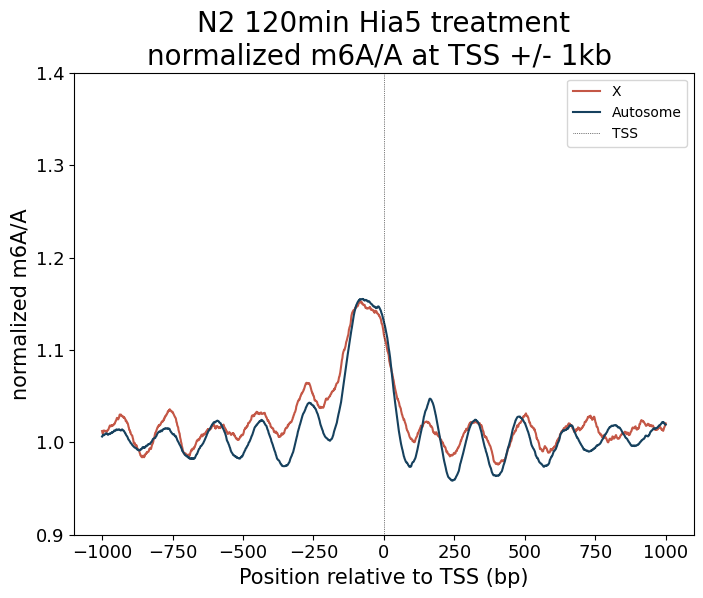

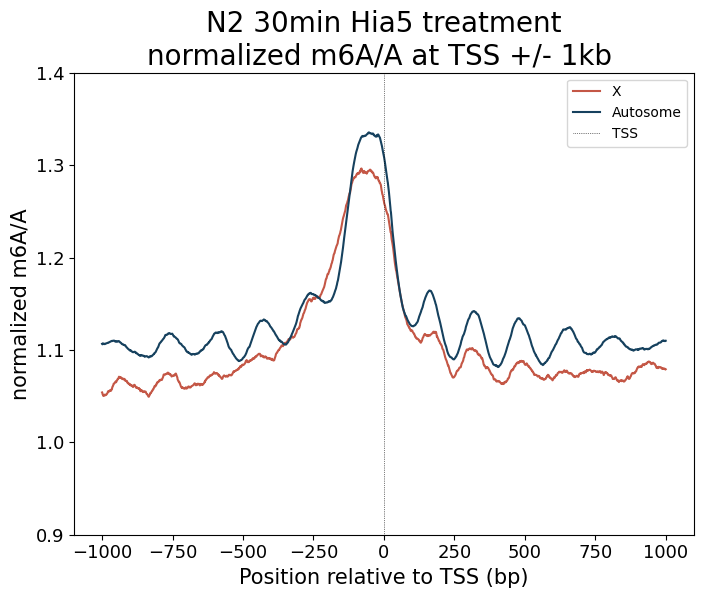

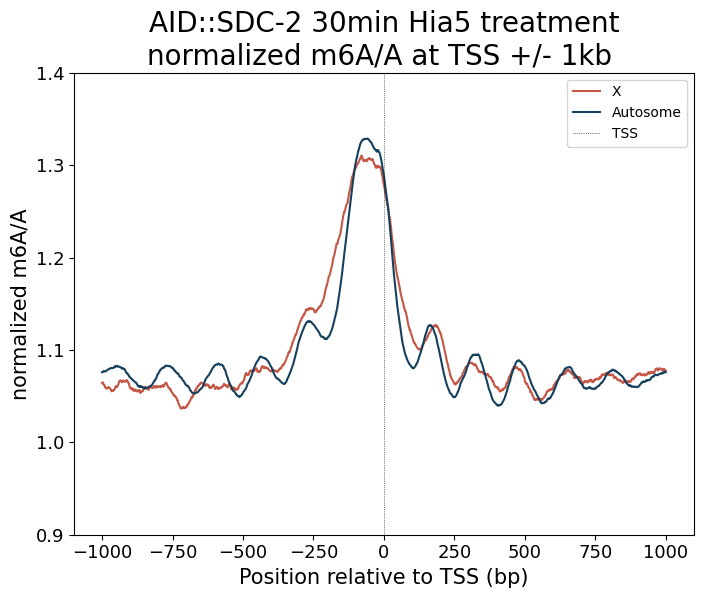

In [5]:

### Plots
size = (8,6)
fig, ax = plt.subplots(figsize=size)
sns.lineplot(data=TSS_4,
             y="norm_m6A_frac_smooth",
             x="pos",hue="chr_type",
             #palette=["#61a661","#ae64ad"])
             palette=["#c45746","#16415e"])
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel('Position relative to TSS (bp)', fontsize=15)
plt.ylabel('normalized m6A/A', fontsize=15)
ax.set_ylim(0.9,1.4)
ax.axvline(0,color="black",lw=0.5,ls=":",label="TSS")
ax.legend()
plt.title('N2 120min Hia5 treatment\nnormalized m6A/A at TSS +/- 1kb ', fontsize=20)
plt.savefig('jupyter_output/N2_120min_TSS_XvsA.png',dpi=300)
plt.savefig('jupyter_output/N2_120min_TSS_XvsA.svg')
plt.show()


size = (8,6)
fig, ax = plt.subplots(figsize=size)
sns.lineplot(data=TSS_D,
             y="norm_m6A_frac_smooth",
             x="pos",hue="chr_type",
             palette=["#c45746","#16415e"])
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel('Position relative to TSS (bp)', fontsize=15)
plt.ylabel('normalized m6A/A', fontsize=15)
ax.set_ylim(0.9,1.4)
ax.axvline(0,color="black",lw=0.5,ls=":",label="TSS")
ax.legend()
plt.title('N2 30min Hia5 treatment\nnormalized m6A/A at TSS +/- 1kb ', fontsize=20)
plt.savefig('jupyter_output/N2_30min_TSS_XvsA.png',dpi=300)
plt.savefig('jupyter_output/N2_30min_TSS_XvsA.svg')
plt.show()


size = (8,6)
fig, ax = plt.subplots(figsize=size)
sns.lineplot(data=TSS_H,
             y="norm_m6A_frac_smooth",
             x="pos",hue="chr_type",
             palette=["#c45746","#16415e"])
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel('Position relative to TSS (bp)', fontsize=15)
plt.ylabel('normalized m6A/A', fontsize=15)
ax.set_ylim(0.9,1.4)
ax.axvline(0,color="black",lw=0.5,ls=":",label="TSS")
ax.legend()
plt.title('AID::SDC-2 30min Hia5 treatment\nnormalized m6A/A at TSS +/- 1kb ', fontsize=20)
plt.savefig('jupyter_output/AID-SDC2_30min_TSS_XvsA.png',dpi=300)
plt.savefig('jupyter_output/AID-SDC2_30min_TSS_XvsA.svg')
plt.show()